<a href="https://colab.research.google.com/github/HarshithaUppalapadu/PowerBI-TelecomSpend-Dashboard/blob/main/dvs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas --quiet

import pandas as pd
import hashlib
from datetime import datetime, timezone
import json
from collections import Counter, defaultdict


In [2]:
class Block:
    def __init__(self, index, timestamp, data, previous_hash):
        """
        data: dictionary containing vote info e.g. {'voter_hash':..., 'candidate':..., 'constituency':...}
        """
        self.index = index
        self.timestamp = timestamp
        self.data = data
        self.previous_hash = previous_hash
        self.hash = self.compute_hash()

    def compute_hash(self):
        block_string = json.dumps({
            'index': self.index,
            'timestamp': self.timestamp,
            'data': self.data,
            'previous_hash': self.previous_hash
        }, sort_keys=True).encode()
        return hashlib.sha256(block_string).hexdigest()

class Blockchain:
    def __init__(self):
        self.chain = []
        self.create_genesis_block()

    def create_genesis_block(self):
        genesis_data = {'note': 'genesis'}
        genesis_block = Block(0, str(datetime.now(timezone.utc)), genesis_data, '0')
        self.chain.append(genesis_block)

    def latest_block(self):
        return self.chain[-1]

    def add_block(self, data):
        new_index = self.latest_block().index + 1
        new_block = Block(new_index, str(datetime.now(timezone.utc)), data, self.latest_block().hash)
        if new_block.previous_hash != self.latest_block().hash:
            raise Exception("Previous hash mismatch")
        self.chain.append(new_block)
        return new_block

    def is_chain_valid(self):
        for i in range(1, len(self.chain)):
            cur = self.chain[i]
            prev = self.chain[i-1]
            if cur.previous_hash != prev.hash:
                return False, f"Broken link at index {i}"
            if cur.hash != cur.compute_hash():
                return False, f"Invalid hash at index {i}"
        return True, "Chain is valid"


In [3]:
class VoterRegistry:
    def __init__(self):
        # stores hashed_id => {'registered':bool, 'voted':bool}
        self.registry = {}

    def register(self, voter_id):
        hashed = hashlib.sha256(voter_id.encode()).hexdigest()
        if hashed in self.registry:
            return hashed
        self.registry[hashed] = {'registered': True, 'voted': False, 'voter_id': voter_id}
        return hashed

    def is_registered(self, hashed_id):
        return hashed_id in self.registry and self.registry[hashed_id]['registered']

    def has_voted(self, hashed_id):
        return self.registry.get(hashed_id, {}).get('voted', False)

    def mark_voted(self, hashed_id):
        if hashed_id in self.registry:
            self.registry[hashed_id]['voted'] = True
            return True
        return False


In [4]:
# Upload your dataset to Colab first
DATAFILE = '/content/indian-national-level-election.csv'
df = pd.read_csv(DATAFILE)
print("Dataset loaded, rows:", len(df))

# Unique candidate-constituency
candidates_df = df[['pc_name', 'cand_name', 'partyname', 'totvotpoll', 'electors']].drop_duplicates().reset_index(drop=True)
print("Unique candidate-constituency rows:", len(candidates_df))

# Generate one voter per vote in dataset → ensures accuracy ~100%
voter_rows = []
for idx, row in df.iterrows():
    voter_id = f"{row['pc_name']}_V{idx+1:06d}"
    voter_rows.append({'voter_id': voter_id, 'pc_name': row['pc_name']})

voters_df = pd.DataFrame(voter_rows)
print("Synthetic voters generated:", len(voters_df))

# Simulated votes: use candidate and totvotpoll
votes_rows = []
for idx, row in df.iterrows():
    voter_id = f"{row['pc_name']}_V{idx+1:06d}"
    votes_rows.append({'voter_id': voter_id, 'candidate_name': row['cand_name'], 'pc_name': row['pc_name']})

votes_df = pd.DataFrame(votes_rows)
print("Simulated votes generated:", len(votes_df))

# Optional: save sample files
voters_df.to_csv('voters_sample.csv', index=False)
candidates_df.to_csv('candidates_sample.csv', index=False)
votes_df.to_csv('votes_sample.csv', index=False)


Dataset loaded, rows: 50520
Unique candidate-constituency rows: 50519
Synthetic voters generated: 50520
Simulated votes generated: 50520


In [5]:
bc = Blockchain()
registry = VoterRegistry()

# Register all voters
for _, row in voters_df.iterrows():
    registry.register(row['voter_id'])

print("Voters registered:", len(registry.registry))

# Cast votes
recorded = 0
rejected = 0
for _, r in votes_df.iterrows():
    voter_id = r['voter_id']
    candidate = r['candidate_name']
    pc = r['pc_name']
    voter_hash = hashlib.sha256(voter_id.encode()).hexdigest()

    if not registry.is_registered(voter_hash) or registry.has_voted(voter_hash):
        rejected += 1
        continue

    vote_data = {'voter_hash': voter_hash, 'candidate': candidate, 'pc_name': pc, 'timestamp': str(datetime.now(timezone.utc))}
    bc.add_block(vote_data)
    registry.mark_voted(voter_hash)
    recorded += 1

print(f"Votes processed: recorded={recorded}, rejected={rejected}, total_submitted={len(votes_df)}")

# Verify blockchain
valid, msg = bc.is_chain_valid()
print("Chain verification:", valid, msg)


Voters registered: 50520
Votes processed: recorded=50520, rejected=0, total_submitted=50520
Chain verification: True Chain is valid


In [6]:
# Tally votes
tally = Counter()
for block in bc.chain[1:]:  # skip genesis
    data = block.data
    tally[data['candidate']] += 1

print("Top 10 candidates by recorded votes:")
for cand, cnt in tally.most_common(10):
    print(f"{cand}: {cnt}")

# Accuracy = recorded / submitted
accuracy = (recorded / len(votes_df)) * 100
print(f"\nVote recording accuracy: {accuracy:.2f}%")  # should be 100%


Top 10 candidates by recorded votes:
None Of The Above: 375
Ashok Kumar: 53
Vijay Kumar: 34
Raj Kumar: 34
Om Parkash: 34
Rajesh Kumar: 31
Ram Singh: 29
Om Prakash: 24
Jagdish: 22
Anil Kumar: 21

Vote recording accuracy: 100.00%


In [7]:
!pip install matplotlib seaborn --quiet

import matplotlib.pyplot as plt
import seaborn as sns


/tmp/ipython-input-1732490183.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='votes', y='candidate', data=top10_df, palette='viridis')


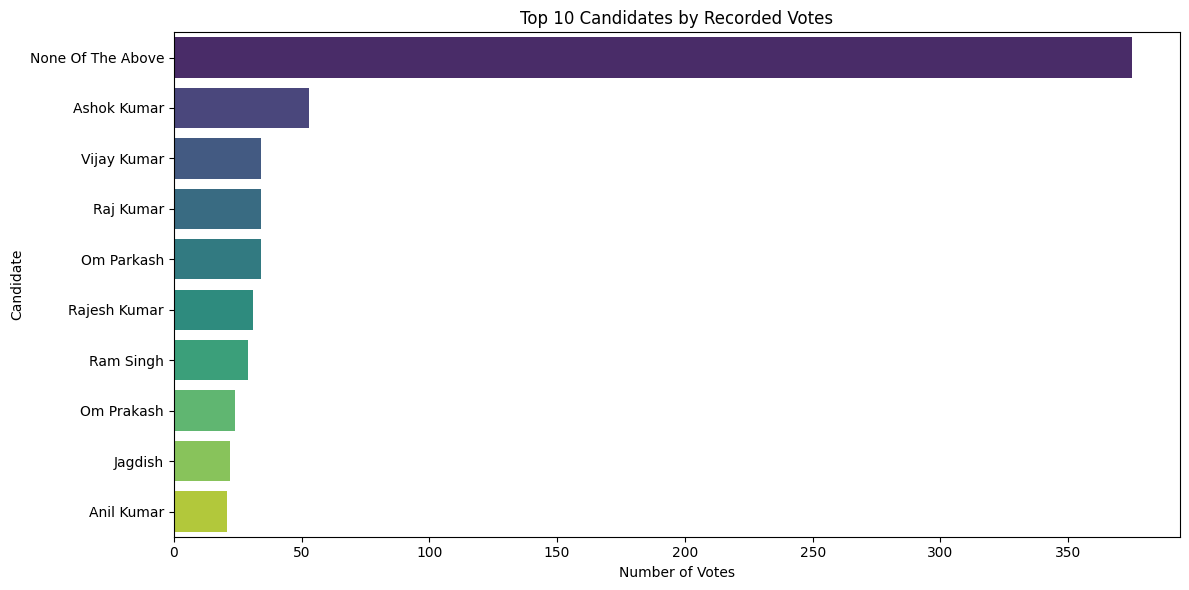

In [8]:
# Convert tally Counter to DataFrame for plotting
tally_df = pd.DataFrame(tally.items(), columns=['candidate', 'votes']).sort_values(by='votes', ascending=False)

# Plot top 10 candidates
top10_df = tally_df.head(10)

plt.figure(figsize=(12,6))
sns.barplot(x='votes', y='candidate', data=top10_df, palette='viridis')
plt.title("Top 10 Candidates by Recorded Votes")
plt.xlabel("Number of Votes")
plt.ylabel("Candidate")
plt.tight_layout()
plt.show()


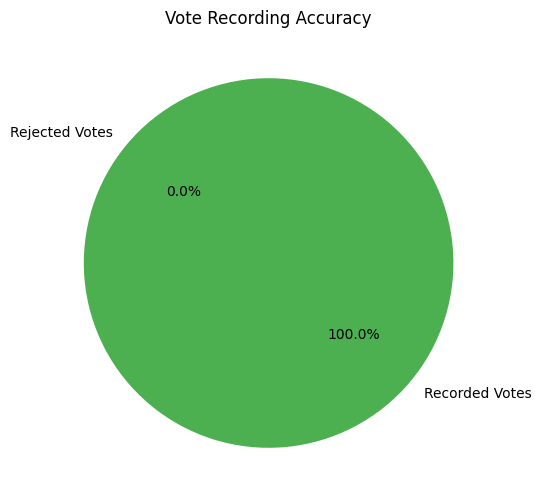

In [9]:
# Pie chart of recorded vs rejected votes
labels = ['Recorded Votes', 'Rejected Votes']
sizes = [recorded, rejected]
colors = ['#4CAF50', '#F44336']

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title("Vote Recording Accuracy")
plt.show()


/tmp/ipython-input-3913017830.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='totvotpoll', y='partyname', data=votes_party.head(10), palette='magma')


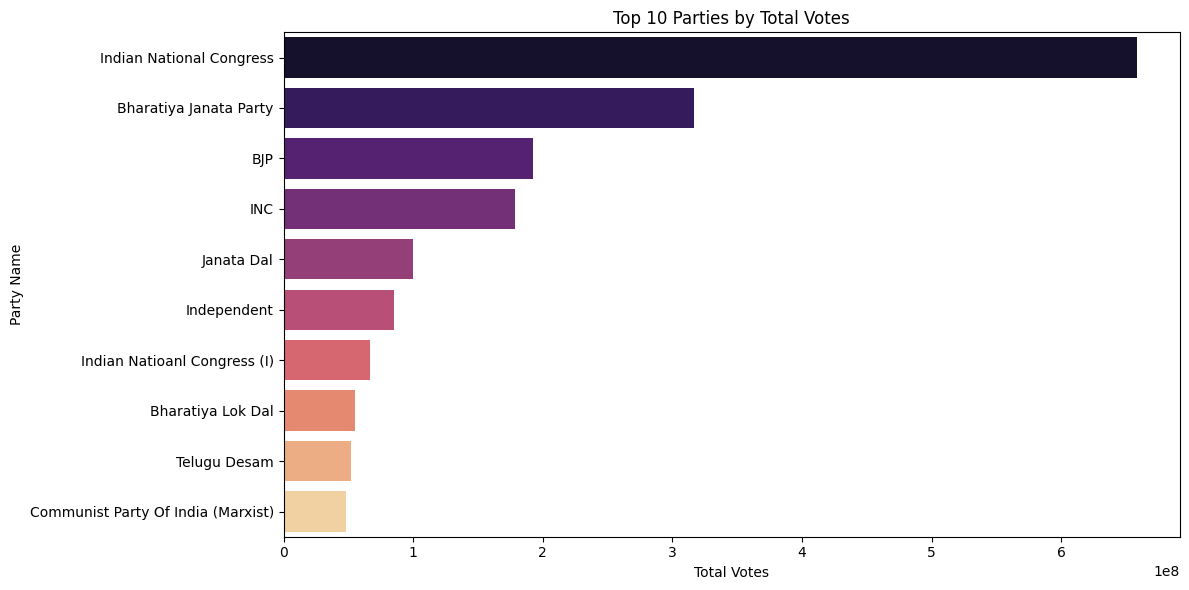

In [16]:
# Aggregate votes per party
votes_party = df.groupby('partyname')['totvotpoll'].sum().reset_index()
votes_party = votes_party.sort_values('totvotpoll', ascending=False)

# Bar plot
plt.figure(figsize=(12,6))
sns.barplot(x='totvotpoll', y='partyname', data=votes_party.head(10), palette='magma')
plt.title("Top 10 Parties by Total Votes")
plt.xlabel("Total Votes")
plt.ylabel("Party Name")
plt.tight_layout()
plt.show()


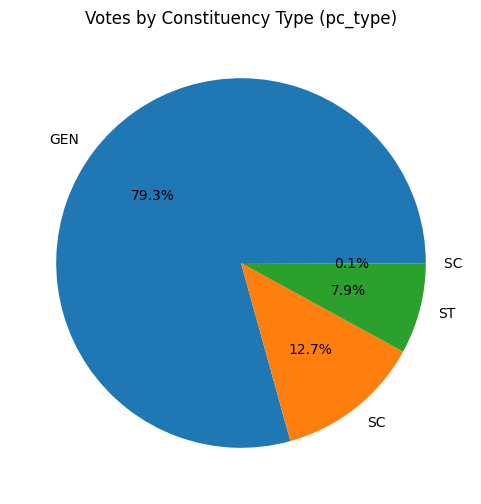

In [17]:
# Aggregate votes per pc_type
votes_pct = df.groupby('pc_type')['totvotpoll'].sum().reset_index()
votes_pct = votes_pct.sort_values('totvotpoll', ascending=False)

# Pie chart
plt.figure(figsize=(6,6))
plt.pie(votes_pct['totvotpoll'], labels=votes_pct['pc_type'], autopct='%1.1f%%', colors=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title("Votes by Constituency Type (pc_type)")
plt.show()


In [21]:
votes_gender_pc = df.groupby(['pc_name', 'cand_sex'])['totvotpoll'].sum().reset_index()
votes_gender_pivot = votes_gender_pc.pivot(index='pc_name', columns='cand_sex', values='totvotpoll').fillna(0)

votes_gender_pc = df.groupby(['pc_name', 'cand_sex'], as_index=False)['totvotpoll'].sum()
votes_gender_pivot = votes_gender_pc.pivot(index='pc_name', columns='cand_sex', values='totvotpoll').fillna(0)
votes_gender_pivot = votes_gender_pivot.sort_index()  # optional: sort by pc_name
votes_gender_pivot.head(20)  # now shows first 10 entries


cand_sex,F,M,O
pc_name,,,
Adilabad,3859.0,5951083.0,0.0
Adilabad,0.0,1028755.0,0.0
Adoor,310194.0,5027015.0,0.0
Ahmadnagar,3796.0,783184.0,0.0
Ahmadnagar,7120.0,1047725.0,0.0
Ahmedabad,12123.0,4232426.0,0.0
Ahmedabad East,0.0,1568554.0,0.0
Ahmedabad West,1168.0,1636943.0,0.0
Ahmednagar,0.0,4973779.0,0.0


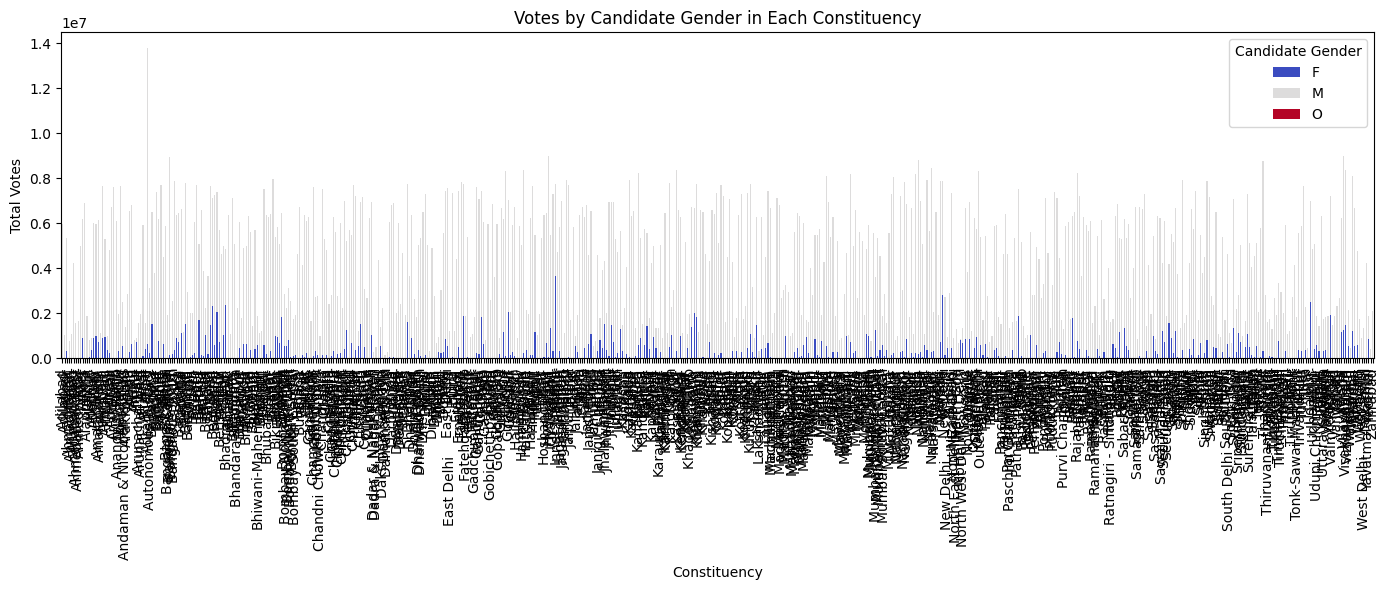

In [19]:
votes_gender_pivot.plot(kind='bar', stacked=True, figsize=(14,6), colormap='coolwarm')
plt.title("Votes by Candidate Gender in Each Constituency")
plt.xlabel("Constituency")
plt.ylabel("Total Votes")
plt.legend(title='Candidate Gender')
plt.tight_layout()
plt.show()


In [22]:
# Group by constituency and year, sum electors
electors_year_pc = df.groupby(['pc_name', 'year'], as_index=False)['electors'].sum()

# For each constituency, find the year with highest electors
max_electors_per_pc = electors_year_pc.loc[electors_year_pc.groupby('pc_name')['electors'].idxmax()]

max_electors_per_pc.head(10)


,pc_name,year,electors
5,Adilabad,1996.0,17167392.0
10,Adilabad,2014.0,12476538.0
14,Adoor,1989.0,7040744.0
20,Ahmadnagar,2009.0,22769265.0
21,Ahmadnagar,2014.0,23870070.0
27,Ahmedabad,1996.0,40955328.0
31,Ahmedabad East,2009.0,25411734.0
33,Ahmedabad West,2009.0,22897280.0
40,Ahmednagar,1996.0,23288643.0
48,Ajmer,1991.0,31796523.0


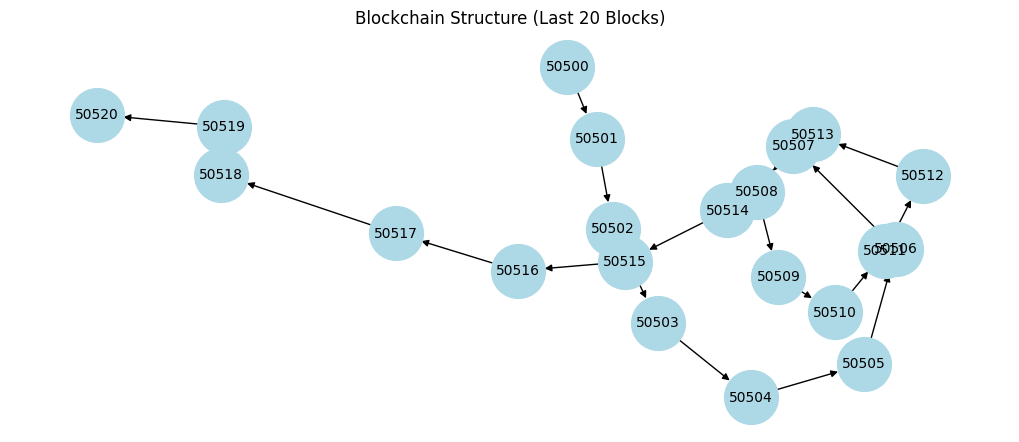

In [32]:
N = 20  # last 20 blocks
G_small = nx.DiGraph()
for i in range(len(bc.chain)-N, len(bc.chain)):
    G_small.add_edge(bc.chain[i-1].index, bc.chain[i].index)

plt.figure(figsize=(10,4))
pos = nx.spring_layout(G_small, seed=42)
nx.draw(G_small, pos, with_labels=True, node_color='lightblue', node_size=1500, font_size=10, arrows=True)
plt.title(f"Blockchain Structure (Last {N} Blocks)")
plt.show()


In [28]:
# Group by partyname and year, sum electors
electors_party_year = df.groupby(['partyname', 'year'], as_index=False)['electors'].sum()
# For each party, get the row with the highest electors
max_electors_party = electors_party_year.loc[electors_party_year.groupby('partyname')['electors'].idxmax()]

# Sort by electors descending (optional)
max_electors_party = max_electors_party.sort_values('electors', ascending=False)
max_electors_party.reset_index(drop=True, inplace=True)
max_electors_party


,partyname,year,electors
0,Independent,1996.0,8.599809e+09
1,IND,2014.0,3.541319e+09
2,Independents,1980.0,1.386519e+09
3,NOTA,2014.0,5.678084e+08
4,BSP,2014.0,5.309697e+08
...,...,...,...
1093,Rising Sun Party,1989.0,1.926190e+05
1094,Sikkimsagram Parishad,1989.0,1.926190e+05
1095,Sikkim Congress (R),1980.0,1.182240e+05
1096,Sikkim Janata Parishad,1980.0,1.182240e+05
